# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

In [2]:
!pip install gymnasium[toy_text,classic_control]
!apt-get install -y python3-dev python3-pip python3-setuptools swig
!apt-get install -y libgl1-mesa-dev
!pip install Box2D
!pip install catboost
!pip install joblib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following additional packages will be installed:
  python3-wheel swig4.0
Suggested packages:
  python-setuptools-doc swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  python3-pip python3-setuptools python3-wheel swig swig4.0
0 upgraded, 5 newly installed, 0 to remove and 32 not upgraded.
Need to get 2,793 kB of archives.
After this operation, 14.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-setuptools all 59.6.0-1.2ubuntu0.22.04.2 [340 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.1 [32.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip all 22.0.2+dfsg-1ubuntu0.5 [1,306 

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [68]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def generate_session(env, agent, t_max, n_actions, strategy_helper=lambda state, proba: proba, reward_helper=lambda state: 0.):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0
    addition_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]
        probs = strategy_helper(s, probs)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(range(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        addition_reward += reward_helper(s)

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward, addition_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile, great_or_equal=True):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward > reward_threshold or (reward == reward_threshold and great_or_equal):
            elite_states.extend(states)
            elite_actions.extend(actions)

    return elite_states, elite_actions


from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


# Training loop
Generate sessions, select N best and fit to those.

mean reward = 149.020, threshold=169.000


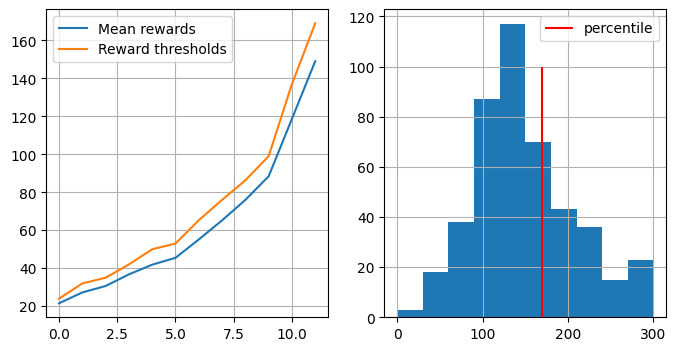

In [ ]:
# if you see "<classname> has no attribute .env", remove .env or update gym
# env = gym.make("CartPole-v0", render_mode="rgb_array").env

# env.reset()
# n_actions = env.action_space.n
# state_dim = env.observation_space.shape[0]

# plt.imshow(env.render())
# print("state vector dim =", state_dim)
# print("n_actions =", n_actions)

# env.close()


# from sklearn.neural_network import MLPClassifier

# # agent = MLPClassifier(
# #     hidden_layer_sizes=(20, 20),
# #     activation="tanh",
# # )

# # initialize agent to the dimension of state space and number of actions
# # agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


# n_sessions = 450  # sample this many sessions
# percentile = 70  # discard this percentage of sessions with lowest rewards
# learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

# # log = []

# for i in range(8, 12):
#     %time sessions = [ generate_session(env, agent, 300, n_actions) for _ in range(n_sessions)]

#     states_batch, actions_batch, rewards_batch = zip(*sessions)

#     elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

#     agent.partial_fit(elite_states, elite_actions, range(n_actions))

#     show_progress(
#         rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
#     )

#     if np.mean(rewards_batch) > 190:
#         print("You Win! You may stop training now via KeyboardInterrupt.")


# Results

In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


## Проблема падения качества

На финальном этапе обучение происходит постепенная потеря качества стратегии. По всей видимости это связано с тем, что алгоритм в конце перестаёт отбирать лучшие стратегии, а вместо этого начинает забрасывать в элиту только запуски с удачными стартовыми положениями, игнорируя при этом менее удачные старты. Это приводит к тому, что в new_policy неудачные состояния получают равномерное распределение по действиям, и это ухудшает качество.

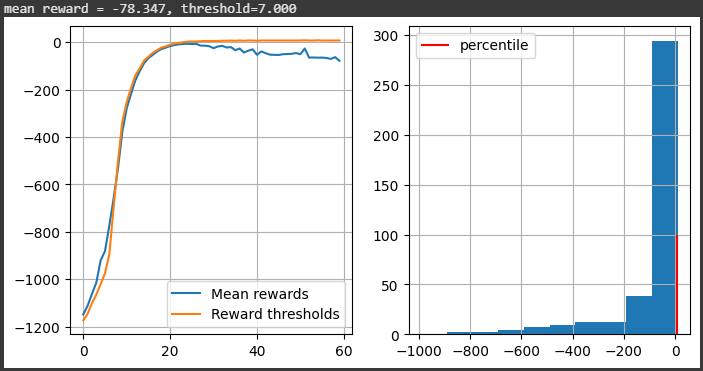

(n_sessions = 450, percentile = 50, learning_rate = 0.5)

## Решение №1

Снизив параметр percentile до 30, получилось избежать(значительно замедлить)падение качетва. А когда была убрана рандомизация стратегий в пользу того, чтобы всегда выбирать лучшее, на тестировании получилось достичь средней награды в 5.888.

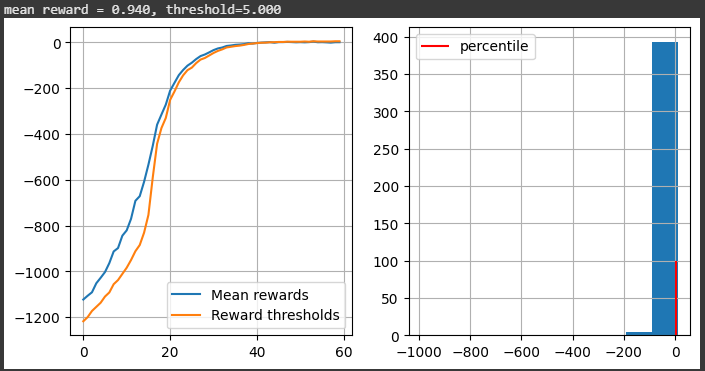

(n_sessions = 450, percentile = 30, learning_rate = 0.5)

## Решение №2

Сделать так, чтобы для тех состояний, которые не попали в elite, стратегия не обновлялась.

Результат превосходит ожидания - гипотеза о причине потери качества подтвердилась

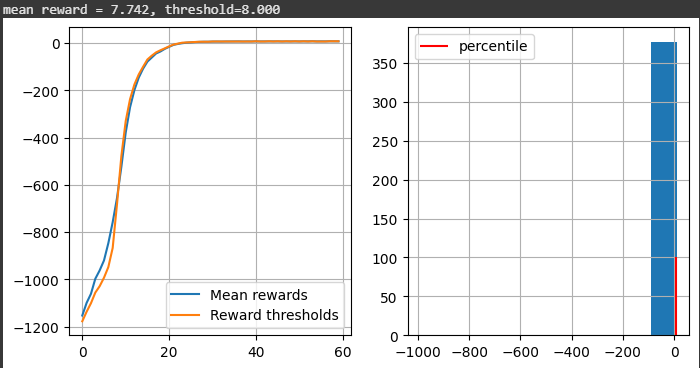

(n_sessions = 450, percentile = 50, learning_rate = 0.5)


# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)


In [6]:
from collections import defaultdict
# from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
## COMMENT THIS SECTION TO CONTINUE LEARNING
lunar_d = {}
lunar_d["env"] = gym.make("LunarLander-v3", continuous=False)
lunar_d["env"].reset()

lunar_d["n_actions"] = lunar_d["env"].action_space.n
lunar_d["state_dim"] = lunar_d["env"].observation_space.shape[0]

lunar_d["n_sessions"] = 450  # sample this many sessions
lunar_d["percentile"] = 70  # discard this percentage of sessions with lowest rewards

lunar_d["agent"] = MLPClassifier(
    hidden_layer_sizes=(60, 60, 20),
    activation="relu",
)
lunar_d["agent"].partial_fit([lunar_d["env"].reset()[0]] * lunar_d["n_actions"], range(lunar_d["n_actions"]), range(lunar_d["n_actions"]))

def after_touching(state, proba):
    if state[6] and state[7]:
        return np.array([1., 0., 0., 0.])
    else:
        return proba

def addition_action_reward(a):
    if a == 1 or a == 3:
        return -0.1
    elif a == 2:
        return -0.5
    return 0.0

# lunar_d["agent"] = CatBoostClassifier(
#     iterations=500,         # Количество деревьев (достаточно для хорошего обучения)
#     depth=6,                # Глубина деревьев (оптимальный баланс между сложностью и переобучением)
#     learning_rate=0.05,     # Скорость обучения (меньше = стабильнее, но дольше)
#     loss_function='MultiClass',  # Классификация нескольких классов (4 действия)
#     eval_metric='MultiClass',    # Оценка качества на нескольких классах
#     l2_leaf_reg=3,          # L2-регуляризация (борьба с переобучением)
#     random_strength=1,      # Случайность при построении деревьев (устойчивость к шуму)
#     bagging_temperature=1,   # Бутстрепинг, увеличивает обобщающую способность
# )

lunar_d["log"] = []
buffer = []
## END OF SECTION


In [ ]:
def simple_strategy()

mean reward = 236.416, threshold=280.756


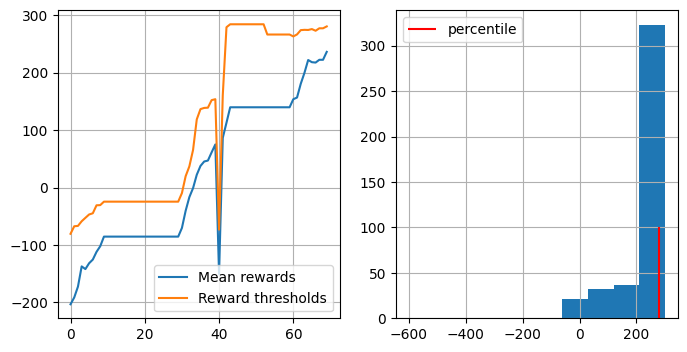

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
lunar_d["percentile"] = 70
for i in range(0, 1):
    %time sessions = [ generate_session(lunar_d["env"], lunar_d["agent"], 300, lunar_d["n_actions"], after_touching) for _ in range(lunar_d["n_sessions"])]

    states_batch, actions_batch, rewards_batch= zip(*sessions)
    # print(addition_rewards_batch)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, lunar_d["percentile"])

    lunar_d["agent"].partial_fit(elite_states, elite_actions, range(lunar_d["n_actions"]))

    show_progress(
        rewards_batch, lunar_d["log"], lunar_d["percentile"], reward_range=[-600, 300]
    )

    if np.mean(rewards_batch) > 200:
        print("You Win! You may stop training now via KeyboardInterrupt.")


In [69]:
from joblib import Parallel, delayed

def isolate_session(*args):
    env = gym.make("LunarLander-v3", continuous=False)
    # print(args)
    args = list(args)
    args[0] = env
    return generate_session(*args)

parallel = Parallel(n_jobs=2)

max_buffer_size = 3

lunar_d["percentile"] = 70
for i in range(0, 50):
    %time sessions = [ generate_session(lunar_d["env"], lunar_d["agent"], 300, lunar_d["n_actions"], after_touching) for _ in range(lunar_d["n_sessions"])]

    states_batch, actions_batch, rewards_batch, _ = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, lunar_d["percentile"])

    buffer.insert(0, (elite_states, elite_actions))
    if len(buffer) > max_buffer_size:
        buffer.pop()

    buffer_states = []
    buffer_actions = []
    for states, actions in buffer:
        buffer_states.extend(states)
        buffer_actions.extend(actions)

    lunar_d["agent"].partial_fit(buffer_states, buffer_actions, range(lunar_d["n_actions"]))

    show_progress(
        rewards_batch, lunar_d["log"], lunar_d["percentile"], reward_range=[-600, 300]
    )

    if np.mean(rewards_batch) > 200:
        print("You Win! You may stop training now via KeyboardInterrupt.")


AssertionError: make sure probabilities are a vector (hint: np.reshape)

ValueError: not enough values to unpack (expected 4, got 3)

In [7]:
from collections import defaultdict
import torch
from torch import nn



## COMMENT THIS SECTION TO CONTINUE LEARNING
car_d = {}
car_d["env"] = gym.make("MountainCar-v0").env
# car_d["env"].env.unwrapped.TimeLimit = 10000
car_d["env"].reset()

car_d["n_actions"] = car_d["env"].action_space.n
car_d["state_dim"] = car_d["env"].observation_space.shape[0]

car_d["n_sessions"] = 100  # sample this many sessions
car_d["percentile"] = 70  # discard this percentage of sessions with lowest rewards

car_d["agent"] = MLPClassifier(
    hidden_layer_sizes=(60, 60, 20),
    activation="relu",
)
car_d["log"] = []

car_d["agent"].partial_fit([car_d["env"].reset()[0]] * car_d["n_actions"], range(car_d["n_actions"]), range(car_d["n_actions"]))

def encourage_speed(state):
    return abs(state[1])*10


NameError: name 'MLPClassifier' is not defined

mean reward = -142.367, threshold=-113.000


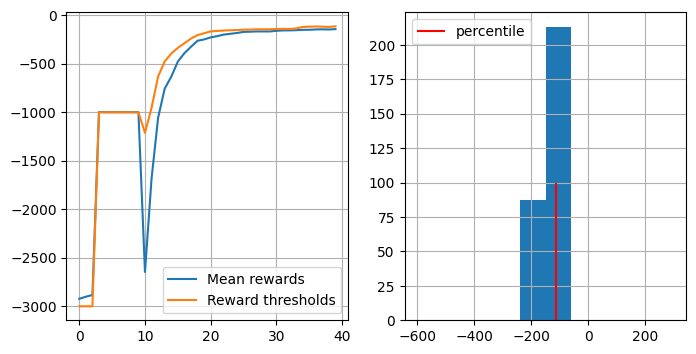

In [77]:
# import queue

# max_buffer_size = 3

car_d["percentile"] = 90
for i in range(0, 10):
    %time sessions = [ generate_session(car_d["env"], car_d["agent"], 4000, car_d["n_actions"]) for _ in range(car_d["n_sessions"])]
    # print(sessions[0])
    # print(sessions[1])
    states_batch, actions_batch, rewards_batch, addition_rewards_batch= zip(*sessions)
    # print(states_batch[0])
    # print(actions_batch[0])
    # print(rewards_batch[0])
    # print(addition_rewards_batch)
    # break
    # print(rewards_batch[:4])
    # print(addition_rewards_batch[:4])
    total_rewards = np.array(rewards_batch) + np.array(addition_rewards_batch)
    # tresh = np.percentile(total_rewards, car_d["percentile"])
    # print(rewards_batch.shape)
    # print(addition_rewards_batch.shape)
    # print(rewards_batch + addition_rewards_batch)
    # print(f"tresh = {tresh}")
    # print( > tresh).sum())
    elite_states, elite_actions = select_elites(states_batch, actions_batch, total_rewards, car_d["percentile"], great_or_equal=False)
    # print(elite_states[0])
    # print(elite_actions[0])
    # break

    # buffer.insert(0, (elite_states, elite_actions))
    # if len(buffer) > max_buffer_size:
    #     buffer.pop()

    # buffer_states = []
    # buffer_actions = []
    # print(buffer_states[:4])
    # print(buffer_actions[:4])
    # for states, actions in buffer:
    #     buffer_states.extend(states)
    #     buffer_actions.extend(actions)
    # print(elite_states[:3])
    # print(elite_actions[:3])
    # break

    car_d["agent"].partial_fit(elite_states, elite_actions, range(car_d["n_actions"]))

    show_progress(
        rewards_batch, car_d["log"], car_d["percentile"], reward_range=[-600, 300]
    )

    if np.mean(rewards_batch) > -100:
        print("You Win! You may stop training now via KeyboardInterrupt.")


In [80]:
 env = gym.make("LunarLander-v3", continuous=True)

 env.reset()

 env.step(np.array([1.0, 1.0]))

(array([ 0.00643778,  1.3863488 ,  0.33788115, -0.5280157 , -0.00885373,
        -0.10509664,  0.        ,  0.        ], dtype=float32),
 2.2596634048634727,
 False,
 False,
 {})

In [91]:
from collections import defaultdict
# from catboost import CatBoostClassifier
from sklearn.neural_network import MLPRegressor
import torch
from torch import nn

## COMMENT THIS SECTION TO CONTINUE LEARNING

# class Agent(nn.Module):
#     def __init__(self):
#         super(Agent, self).__init__()
#         self.lays = nn.Sequential(
#             nn.Linear(8, 30),
#             nn.ReLU(),
#             nn.Linear(30, 30),
#             nn.Dropout(0.15),
#             nn.ReLU(),
#             nn.Linear(30, 15),
#             nn.Dropout(0.15),
#             nn.ReLU(),
#             nn.Linear(15, 2)
#         )
#         self.main_pred = nn.Tanh()

#         self.lateral_pred = nn.Tanh()
#         self.loss = nn.MSELoss()

#     def forward(self, X):
#         lays = self.lays(X)
#         # print(lays)
#         y = torch.hstack((self.main_pred(lays[:, 0]).view(-1, 1), self.lateral_pred(lays[:, 1]).view(-1, 1)))
#         assert y.shape == (X.shape[0], 2), f"y.shape {y.shape}. {self.main_pred(lays[:, 0]).shape}, {self.lateral_pred(lays[:, 1])}"
#         return y

class VerticalAgent(nn.Module):
    def __init__(self):
        super(VerticalAgent, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(10, 1),  # Один выход - только боковой двигатель
        )
        self.main_pred = nn.Tanh()  # Ограничение [0, 1]
        self.loss = nn.HuberLoss()

    def forward(self, X):
        return self.main_pred(self.layers(X))


class LateralAgent(nn.Module):
    def __init__(self):
        super(LateralAgent, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(10, 1),  # Один выход - только боковой двигатель
        )
        self.lateral_pred = nn.Tanh()  # Ограничение [-1, 1]
        self.loss = nn.HuberLoss()

    def forward(self, X):
        return self.lateral_pred(self.layers(X))


# Использование

lunar_c = {}
lunar_c["vertical_agent"] = VerticalAgent()
lunar_c["lateral_agent"] = LateralAgent()


# lunar_c["env"] = gym.make("LunarLander-v3", continuous=True)
lunar_c["env"] = gym.make("LunarLanderContinuous-v3")
lunar_c["env"].reset()

lunar_c["state_dim"] = lunar_c["env"].observation_space.shape[0]

lunar_c["n_sessions"] = 450  # sample this many sessions

# lunar_c["agent"] = Agent()


lunar_c["log"] = []
buffer = []

def after_touching(state, proba):
    if state[6] and state[7]:
        return np.array([0., 0.])
    else:
        return proba

lunar_c["action_noise_std"] = 1.0

def add_noise_to_action(state, y):
    noise = np.random.randn(2)
    noise[0] = noise[0]*lunar_c["action_noise_std"]
    noise[1] = noise[1]*lunar_c["action_noise_std"]*2
    y = y + noise
    # y = np.clip(y, [-1., -1.], [1., 1.])
    return y

def strategy_helper(state, y):
    y = add_noise_to_action(state, y)
    y = after_touching(state, y)
    return y

## END OF SECTION

def generate_continuous_session(env, agent_main, agent_lateral, t_max, strategy_helper=lambda state, proba: proba):
    states, actions = [], []
    total_reward = 0
    # addition_reward = 0

    s, _ = env.reset()

    for t in range(t_max):
        # print(s)
        # print(torch.tensor([s]))
        main = agent_main.forward(torch.tensor([s]))[0][0]
        lateral = agent_lateral.forward(torch.tensor([s]))[0][0]
        y = strategy_helper(s, [main, lateral])

        new_s, r, terminated, truncated, _ = env.step(np.array(y))

        # record sessions like you did before
        states.append(s)
        actions.append(torch.tensor(y))
        total_reward += r
        # addition_reward += reward_helper(s)

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward #, addition_reward


def isolate_session(*args, **kwargs):
    env = gym.make("LunarLanderContinuous-v3")
    # print(args)
    args = list(args)
    args[0] = env

    with torch.no_grad():
        sess = generate_continuous_session(*args, **kwargs)
    return sess


lunar_c["action_noise_std"] = 0.2

In [93]:
import numpy as np

lunar_c["percentile_min"] = 70
lunar_c["percentile_max"] = 90
lunar_c["percentile_period"] = 20
def percentile_sheduler(epoch):
    a = lunar_c["percentile_max"]
    b = lunar_c["percentile_min"]
    p = lunar_c["percentile_period"]
    return -(a-b)/2*np.cos(epoch/p*2*np.pi) + (a-b)/2 + b


In [50]:
percentile_sheduler(21)

50.97886967409693

In [244]:
s, _ = lunar_c["env"].reset()
s

array([-0.00307646,  1.4153188 , -0.31162277,  0.1954992 ,  0.00357159,
        0.07058725,  0.        ,  0.        ], dtype=float32)

In [113]:
from joblib import Parallel, delayed

# max_buffer_size = 1
# lr = 0.005
lunar_c["vertical_agent"].train()
lunar_c["lateral_agent"].train()
main_opt = torch.optim.Adam(lunar_c["vertical_agent"].parameters())
lateral_opt = torch.optim.Adam(lunar_c["lateral_agent"].parameters())
step = 0

parallel = Parallel(n_jobs=2)
max_buffer_size = 3
lunar_c["action_noise_std"] = 0.2

for i in range(0, 20):

    sessions = parallel(delayed(isolate_session)(lunar_c["env"],
                                                     lunar_c["vertical_agent"],
                                                     lunar_c["lateral_agent"],
                                                     500,
                                                     strategy_helper=strategy_helper) for _ in range(lunar_c["n_sessions"]))

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    # print(addition_rewards_batch)

    percentile = percentile_sheduler(len(lunar_c["log"]))
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # print(elite_states[0])

    # buffer.insert(0, (elite_states, elite_actions))
    # if len(buffer) > max_buffer_size:
    #     buffer.pop()

    # buffer_states = []
    # buffer_actions = []
    # for states, actions in buffer:
    #     buffer_states.extend(states)
    #     buffer_actions.extend(actions)

    lunar_c["vertical_agent"].zero_grad()
    lunar_c["lateral_agent"].zero_grad()
    main = lunar_c["vertical_agent"].forward(torch.tensor(elite_states))
    lateral = lunar_c["lateral_agent"].forward(torch.tensor(elite_states))
    # print(y.shape)
    # print(buffer_actions)
    elite_actions = torch.vstack(elite_actions)
    elite_actions = elite_actions.float()
    # print(y.dtype)

    loss_main = lunar_c["vertical_agent"].loss(main, elite_actions[:,0])
    loss_main.backward()
    main_opt.step()

    loss_lateral = lunar_c["lateral_agent"].loss(lateral, elite_actions[:,1])
    loss_lateral.backward()
    lateral_opt.step()

    lunar_c["action_noise_std"] += step
    if lunar_c["action_noise_std"] < 0.02:
        # step = -step
        lunar_c["action_noise_std"] = 0.02

    # if lunar_c["action_noise_std"] > 0.3:
    #     step = -step

    show_progress(
        rewards_batch, lunar_c["log"], percentile, reward_range=[-600, 300]
    )
    if np.mean(rewards_batch) > 200:
        print("You Win! You may stop training now via KeyboardInterrupt.")


Exception ignored in: <function RecordVideo.__del__ at 0x7ef43c971bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py", line 415, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'
Exception ignored in: <function RecordVideo.__del__ at 0x7ef43c971bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py", line 415, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'
Exception ignored in: <function RecordVideo.__del__ at 0x7ef43c971bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py", line 415, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Re

VersionNotFound: Environment version `v3` for environment `LunarLanderContinuous` doesn't exist. It provides versioned environments: [ `v2` ].

In [56]:
def foo(env):
    s, _ = env.reset()
    for _ in range(200):
        env.step([0.03, 0.6])

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("LunarLander-v3", render_mode="rgb_array", continuous=True).env,
    video_folder="./videos_long",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    # env_monitor.env.unwrapped.TimeLimit = 10000
    foo(env_monitor)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos_long folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [111]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("LunarLanderContinuous-v2", render_mode="rgb_array"),
    video_folder="./videos_long",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    # env_monitor.env.unwrapped.TimeLimit = 10000
    with torch.no_grad():
        sessions = [generate_continuous_session(env_monitor, lunar_c["vertical_agent"],lunar_c["lateral_agent"], 3000, strategy_helper=strategy_helper) for _ in range(5)]


AssertionError: 

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.

In [101]:
import gym
import numpy as np

# Создаём среду
env = gym.make("LunarLanderContinuous-v2")

# Параметры нейронной сети
obs_dim = env.observation_space.shape[0]      # размерность наблюдений (8)
action_dim = env.action_space.shape[0]          # размерность действий (2)
hidden_size = 16                                # число нейронов в скрытом слое

# Расчёт общего количества параметров:
# Первый слой: obs_dim x hidden_size (веса) + hidden_size (смещения)
# Второй слой: hidden_size x action_dim (веса) + action_dim (смещения)
n_params = obs_dim * hidden_size + hidden_size + hidden_size * action_dim + action_dim

def get_action(params, obs):
    """
    Функция вычисления действия по наблюдению с использованием параметров политики.
    Используется простая нейронная сеть с одним скрытым слоем и активацией tanh.
    """
    # Извлекаем параметры для первого слоя
    W1 = params[:obs_dim * hidden_size].reshape(obs_dim, hidden_size)
    b1 = params[obs_dim * hidden_size:obs_dim * hidden_size + hidden_size]

    # Извлекаем параметры для второго слоя
    start = obs_dim * hidden_size + hidden_size
    W2 = params[start:start + hidden_size * action_dim].reshape(hidden_size, action_dim)
    b2 = params[start + hidden_size * action_dim:]

    # Прямой проход (forward pass)
    hidden = np.tanh(np.dot(obs, W1) + b1)
    action = np.tanh(np.dot(hidden, W2) + b2)
    return action

def evaluate_policy(params, env, n_episodes=1, render=False):
    """
    Оценивает политику (зафиксированные параметры) по среднему значению суммарной награды
    за n_episodes эпизодов.
    """
    total_reward = 0.0
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            action = get_action(params, obs)
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        total_reward += ep_reward
    return total_reward / n_episodes

# Гиперпараметры алгоритма CEM
n_iterations = 100         # число итераций оптимизации
n_candidates = 50          # число кандидатов на каждой итерации
elite_frac = 0.2           # доля элитных кандидатов
n_elite = int(n_candidates * elite_frac)
noise_std = 1.0            # начальное стандартное отклонение для распределения

# Инициализируем распределение параметров
mean = np.zeros(n_params)
std = np.ones(n_params) * noise_std

best_reward = -np.inf
best_params = None

# Основной цикл CEM
for iteration in range(n_iterations):
    # Генерация кандидатов
    candidates = np.array([mean + std * np.random.randn(n_params) for _ in range(n_candidates)])
    rewards = np.array([evaluate_policy(params, env, n_episodes=1) for params in candidates])

    # Выбор элитных кандидатов с наивысшими наградами
    elite_idxs = rewards.argsort()[-n_elite:]
    elite_candidates = candidates[elite_idxs]

    # Обновление распределения (новые mean и std)
    mean = elite_candidates.mean(axis=0)
    std = elite_candidates.std(axis=0)

    # Сохранение лучших параметров
    if rewards.max() > best_reward:
        best_reward = rewards.max()
        best_params = candidates[rewards.argmax()]

    print(f"Итерация: {iteration:3d} | Лучшая награда: {rewards.max():.2f}")

print("Лучшее значение награды:", best_reward)

# Демонстрация работы лучшей найденной политики
obs = env.reset()
done = False
while not done:
    env.render()
    action = get_action(best_params, obs)
    obs, reward, done, _ = env.step(action)

env.close()


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Итерация:   0 | Лучшая награда: -90.06
Итерация:   1 | Лучшая награда: -32.64
Итерация:   2 | Лучшая награда: 37.80
Итерация:   3 | Лучшая награда: -124.18
Итерация:   4 | Лучшая награда: -49.42
Итерация:   5 | Лучшая награда: 15.52
Итерация:   6 | Лучшая награда: -8.15
Итерация:   7 | Лучшая награда: 42.13
Итерация:   8 | Лучшая награда: -4.43
Итерация:   9 | Лучшая награда: -33.59
Итерация:  10 | Лучшая награда: -31.09
Итерация:  11 | Лучшая награда: 1.72
Итерация:  12 | Лучшая награда: -15.13
Итерация:  13 | Лучшая награда: -5.37
Итерация:  14 | Лучшая награда: 44.21
Итерация:  15 | Лучшая награда: 17.07
Итерация:  16 | Лучшая награда: 37.85
Итерация:  17 | Лучшая награда: 53.29
Итерация:  18 | Лучшая награда: 37.02
Итерация:  19 | Лучшая награда: 33.83
Итерация:  20 | Лучшая награда: 18.90
Итерация:  21 | Лучшая награда: 38.15
Итерация:  22 | Лучшая награда: 63.95
Итерация:  23 | Лучшая награда: 41.11
Итерация:  24 | Лучшая награда: 50.35
Итерация:  25 | Лучшая награда: 52.95
Итера

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [103]:

def generate(env):
    obs, _ = env.reset()
    done = False
    while not done:
        env.render()
        action = get_action(best_params, obs)
        obs, reward, done, _ = env.step(action)

In [112]:

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("LunarLander-v2", render_mode="rgb_array", continuous=True),
    video_folder="./videos_long",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    # env_monitor.env.unwrapped.TimeLimit = 10000
    with torch.no_grad():
        sessions = [generate(env_monitor) for _ in range(5)]


AssertionError: 